# Import Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:06<00:00, 26875152.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# # dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)


CUDA Available? False


In [ ]:
train.data

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: tensor(120.7076)
 - std: tensor(64.1501)
 - var: tensor(4115.2324)
torch.Size([64, 3, 32, 32])
torch.Size([64])


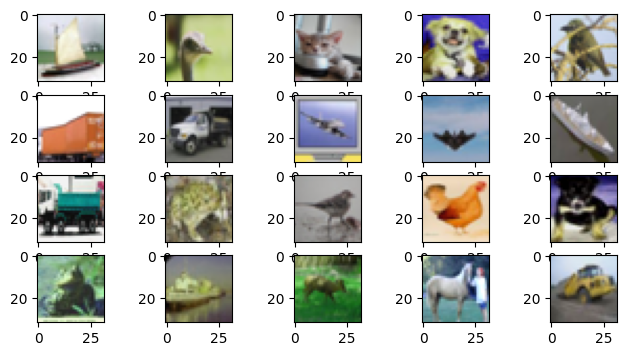

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())
train_data = train.data

torch_tensor = torch.from_numpy(train_data)

print('[Train]')
print(' - Numpy Shape:', train_data.shape)
print(' - Tensor Shape:', torch_tensor.size())
print(' - min:', torch.min(torch_tensor))
print(' - max:', torch.max(torch_tensor))
print(' - mean:', torch.mean(torch_tensor.float()))
print(' - std:', torch.std(torch_tensor.float()))
print(' - var:', torch.var(torch_tensor.float()))

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = images.numpy()

plt.figure(figsize=(8,4))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(np.transpose(images[i],(1,2,0))/2+0.5)

plt.show()

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [ ]:
images.shape

(128, 3, 32, 32)

# The model
Let's start with the model we first saw

In [9]:
from models import S8_BN_Model
Net = S8_BN_Model

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
input_channels = model.convblock1[0].in_channels
summary(model, input_size=(input_channels, 32, 32))
# print(model)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             864
       BatchNorm2d-2           [-1, 32, 34, 34]              64
              ReLU-3           [-1, 32, 34, 34]               0
           Dropout-4           [-1, 32, 34, 34]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             320
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           2,880
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
          Dropout-14           [-1,

In [ ]:
print(model)

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.4145680665969849 Batch_id=390 Accuracy=39.46: 100%|██████████| 391/391 [00:18<00:00, 21.48it/s]



Test set: Average loss: 1.3389, Accuracy: 5120/10000 (51.20%)

EPOCH: 1


Loss=1.2028367519378662 Batch_id=390 Accuracy=56.35: 100%|██████████| 391/391 [00:17<00:00, 22.72it/s]



Test set: Average loss: 1.1911, Accuracy: 5737/10000 (57.37%)

EPOCH: 2


Loss=1.042680025100708 Batch_id=390 Accuracy=62.01: 100%|██████████| 391/391 [00:18<00:00, 21.49it/s]



Test set: Average loss: 1.0539, Accuracy: 6219/10000 (62.19%)

EPOCH: 3


Loss=0.9261765480041504 Batch_id=390 Accuracy=64.86: 100%|██████████| 391/391 [00:17<00:00, 22.38it/s]



Test set: Average loss: 1.0468, Accuracy: 6363/10000 (63.63%)

EPOCH: 4


Loss=0.9178236126899719 Batch_id=390 Accuracy=67.07: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s]



Test set: Average loss: 1.0551, Accuracy: 6336/10000 (63.36%)

EPOCH: 5


Loss=0.9088814854621887 Batch_id=390 Accuracy=68.77: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]



Test set: Average loss: 0.9747, Accuracy: 6565/10000 (65.65%)

EPOCH: 6


Loss=0.8223752975463867 Batch_id=390 Accuracy=70.19: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s]



Test set: Average loss: 1.0681, Accuracy: 6387/10000 (63.87%)

EPOCH: 7


Loss=0.8443827629089355 Batch_id=390 Accuracy=71.05: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s]



Test set: Average loss: 0.8863, Accuracy: 6932/10000 (69.32%)

EPOCH: 8


Loss=0.7345899939537048 Batch_id=390 Accuracy=72.26: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]



Test set: Average loss: 0.8194, Accuracy: 7135/10000 (71.35%)

EPOCH: 9


Loss=0.7010573148727417 Batch_id=390 Accuracy=73.21: 100%|██████████| 391/391 [00:18<00:00, 20.80it/s]



Test set: Average loss: 0.8415, Accuracy: 7060/10000 (70.60%)

EPOCH: 10


Loss=0.5461592674255371 Batch_id=390 Accuracy=73.61: 100%|██████████| 391/391 [00:18<00:00, 21.46it/s]



Test set: Average loss: 0.7593, Accuracy: 7371/10000 (73.71%)

EPOCH: 11


Loss=0.7379406094551086 Batch_id=390 Accuracy=74.42: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]



Test set: Average loss: 0.8216, Accuracy: 7081/10000 (70.81%)

EPOCH: 12


Loss=0.7541571855545044 Batch_id=390 Accuracy=74.82: 100%|██████████| 391/391 [00:18<00:00, 21.33it/s]



Test set: Average loss: 0.8338, Accuracy: 7098/10000 (70.98%)

EPOCH: 13


Loss=0.7851787209510803 Batch_id=390 Accuracy=75.20: 100%|██████████| 391/391 [00:21<00:00, 18.59it/s]



Test set: Average loss: 0.7708, Accuracy: 7319/10000 (73.19%)

EPOCH: 14


Loss=0.8596251606941223 Batch_id=390 Accuracy=75.66: 100%|██████████| 391/391 [00:20<00:00, 19.35it/s]



Test set: Average loss: 0.7601, Accuracy: 7360/10000 (73.60%)

EPOCH: 15


Loss=0.75050950050354 Batch_id=390 Accuracy=76.05: 100%|██████████| 391/391 [00:17<00:00, 22.73it/s]



Test set: Average loss: 0.7749, Accuracy: 7344/10000 (73.44%)

EPOCH: 16


Loss=0.6929557919502258 Batch_id=390 Accuracy=76.29: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]



Test set: Average loss: 0.7956, Accuracy: 7267/10000 (72.67%)

EPOCH: 17


Loss=0.8084834218025208 Batch_id=390 Accuracy=76.64: 100%|██████████| 391/391 [00:17<00:00, 22.88it/s]



Test set: Average loss: 0.7196, Accuracy: 7488/10000 (74.88%)

EPOCH: 18


Loss=0.6410611271858215 Batch_id=390 Accuracy=77.00: 100%|██████████| 391/391 [00:18<00:00, 21.35it/s]



Test set: Average loss: 0.7216, Accuracy: 7550/10000 (75.50%)

EPOCH: 19


Loss=0.7198914885520935 Batch_id=390 Accuracy=77.26: 100%|██████████| 391/391 [00:17<00:00, 22.62it/s]



Test set: Average loss: 0.7201, Accuracy: 7534/10000 (75.34%)



Text(0.5, 1.0, 'Test Accuracy')

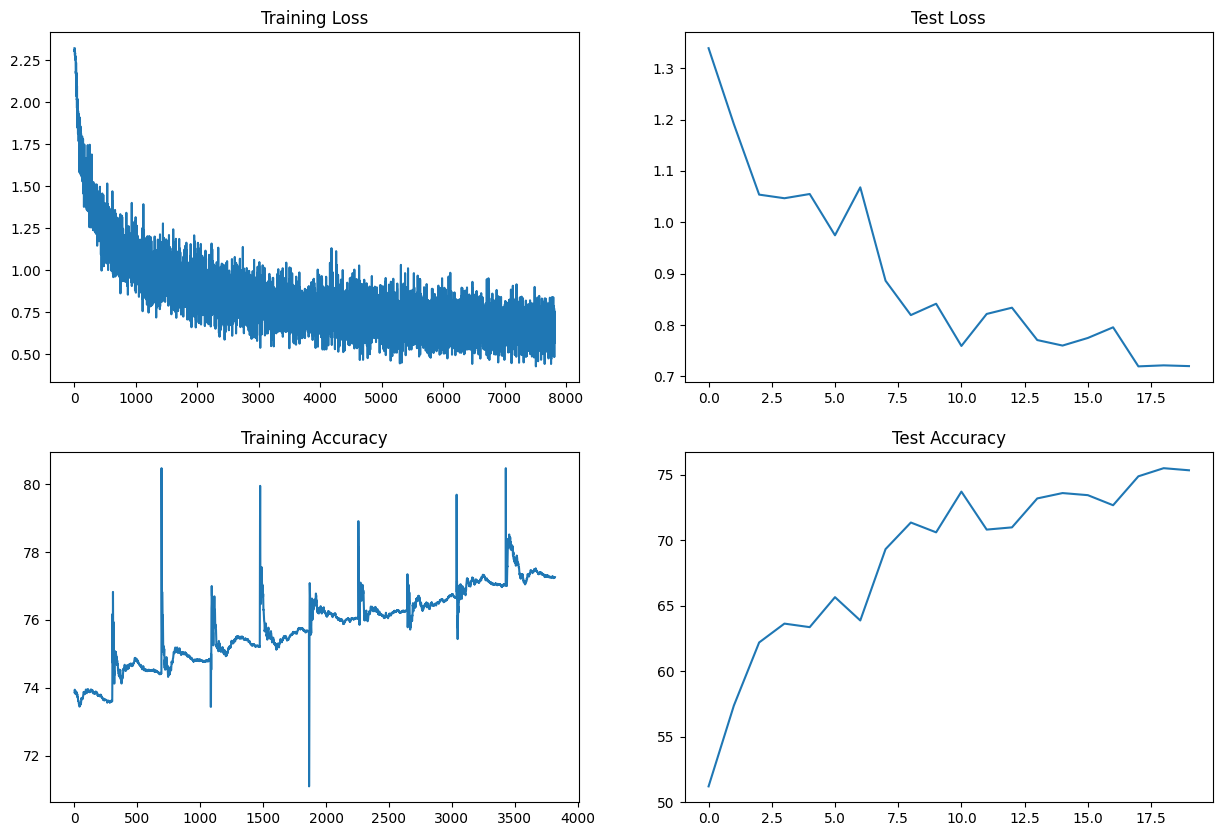

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
import numpy as np

def misclassified(model, testloader):
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  # Testing the model and printing misclassified images
  misclassified_images = []
  misclassified_labels = []
  predicted_label_list = []
  for index in range(500):
      k = np.random.randint(0, len(test_dataloader.dataset))  # random points from test dataset

      img, label = test_dataloader.dataset[k]  # separate the image and label
      img = img.unsqueeze(0)  # adding one dimention
      pred = model(img.to(device))  # Prediction
      predicted_label = pred.argmax().item()
      if label != predicted_label:
          misclassified_labels.append(classes[label])
          misclassified_images.append(img)
          predicted_label_list.append(classes[predicted_label])
      if len(misclassified_labels) == 10:
          break
  print(misclassified_labels)
  plt.figure(figsize=(10, 5))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(misclassified_images[i].squeeze().permute(1,2,0), cmap="gray")
      plt.title(f"Predcited label {predicted_label_list[i]}\n True Label: {misclassified_labels[i]}")
      plt.axis('off')
  plt.show()



['dog', 'truck', 'car', 'car', 'bird', 'horse', 'dog', 'horse', 'deer', 'car']


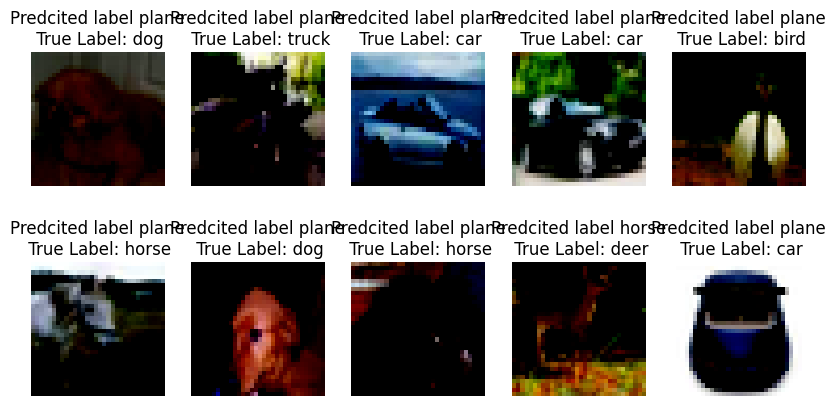

In [ ]:
misclassified(model, test_loader)